## What does this notebook do?
This notebook accesses data from [space-track.org](https://www.space-track.org/) to plot debris vs. payloads count of the top five countries. This data is a part of space-track's [satcat](https://www.space-track.org/documentation#api-basicSpaceDataSatcat) class ( satellite catalogue information ). For any further details, refer to the space-track's API documentation.

## Requirements:
To use this notebook, replace 'username' and 'password' with your existing login credentials. Uncomment and run the required line below to ensure necessary packages are present locally/ in the cloud.

In [1]:
# %pip install matplotlib pandas requests

In [2]:
from datetime import datetime, timezone
import io
import matplotlib.pyplot as plt 
import pandas as pd
import requests

In [3]:
username = None
password = None

if not username or not password:
    print("Enter valid credentials")

siteCred = { 'identity': username, 'password': password }

In [4]:
# Error class to handle 'POST' and 'GET' errors
class HandleError(Exception):
    def __init__(self, args):
        Exception.__init__(self, "Exception raised with args {0}".format(args))
        self.args = args

In [5]:
uriBase = "https://www.space-track.org"
requestLogin = "/ajaxauth/login"
requestQuery = "/basicspacedata/query"

# SATCAT data
classCategory = "/class/satcat"

# OBJECT_TYPE = PAYLOAD & DEBRIS
objectType = "/OBJECT_TYPE/PAYLOAD%2CDEBRIS"

# Orders the data by NORAD_CAT_ID
orderBy = "/orderby/NORAD_CAT_ID%20asc"

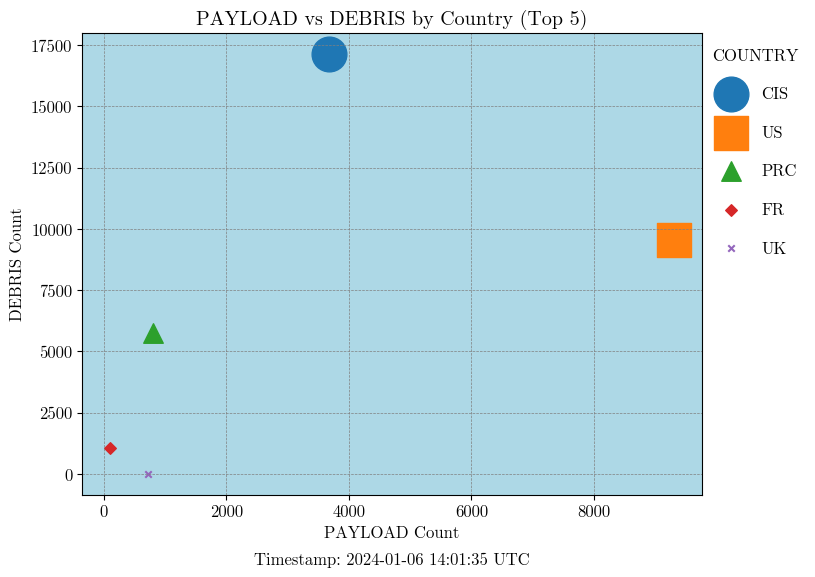

In [6]:
with requests.Session() as session:
    postCheck = session.post(uriBase + requestLogin, data = siteCred)
    if postCheck.status_code != 200:
        raise HandleError('POST')
    
    # Request for PAYLOAD and DEBRIS data from SATCAT
    response1 = session.get(uriBase + requestQuery + classCategory + 
                            objectType + orderBy)
    if response1.status_code != 200:
        raise HandleError('GET')
    
    data1 = response1.text

    dataFrame1 = pd.read_json(io.StringIO(data1))

    """
    Using any available fonts is permissible for the plots, 
    but I chose CMU Serif for aesthetic reasons.
    For Ubuntu, you can install the font package fonts-cmu 
    (using sudo apt install fonts-cmu), which contains the fonts.
    """
    # plt.rcParams['font.family'] = "CMU Serif"
    # plt.rcParams['font.size'] = 12 
    
    plt.rcParams['figure.figsize'] = (8, 6)
    plt.grid(True, color = 'gray', linestyle = '--', linewidth = 0.5)
    plt.gca().set_facecolor('lightblue')

    data = dataFrame1.groupby('COUNTRY')['OBJECT_TYPE'].value_counts().unstack(fill_value = 0)

    data['TOTAL'] = data['PAYLOAD'] + data['DEBRIS']
    data = data.nlargest(5, 'TOTAL')

    # Add your own markers
    markers = ['o', 's', '^', 'D', 'x']

    # Plots the payload vs debris by country graph
    for i, (country, row) in enumerate(data.iterrows()):
        payload = row['PAYLOAD']
        debris = row['DEBRIS']
        total = row['TOTAL']
        plt.scatter(payload, debris, s = total * 0.03, label = country, 
                    marker = markers[i])

    plt.xlabel("PAYLOAD Count")
    plt.ylabel("DEBRIS Count")
    plt.title("PAYLOAD vs DEBRIS by Country (Top 5)")

    timeStamp = datetime.now(timezone.utc).strftime("%Y-%m-%d %H:%M:%S")

    plt.text(0.5, -0.15, f'Timestamp: {timeStamp} UTC', 
         transform = plt.gca().transAxes,
         ha = 'center',
         color = 'black')

    plt.legend(title = 'COUNTRY', loc = "upper right", 
               labelspacing = 1.4, 
               bbox_to_anchor = (1.18, 1), 
               frameon = False)

session.close()